<a href="https://colab.research.google.com/github/JoonghoonChoi/AI_01_Projects/blob/main/n222a_random_forests_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 2 / NOTE 2*

# 📝 Assignment
---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U category_encoders
!pip install -U pandas_profiling

# 랜덤포레스트(Random Forests)

### 1) 캐글 대회를 이어서 진행합니다. EDA, 데이터 전처리 부분을 업데이트 하세요.
- EDA는 항상 완벽할 수 없지요 한 주간 계속 같은 데이터로 과제를 진행하므로 부족한 부분을 추가하거나 논하세요.
- (지금은 feature engineering에 너무 시간을 들이지 마세요!)



In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

a = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_data/prediction-of-h1n1-vaccination/train.csv')
b = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_data/prediction-of-h1n1-vaccination/train_labels.csv')['vacc_h1n1_f']

df_train = pd.merge(a, b, left_index = True, right_index = True)
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_data/prediction-of-h1n1-vaccination/test.csv')

In [38]:
# train/validation/test set 

from sklearn.model_selection import train_test_split

train, val = train_test_split(df_train, test_size = 0.2, stratify = df_train['vacc_h1n1_f'], random_state = 34)

train.shape, val.shape, df_test.shape

((33723, 39), (8431, 39), (28104, 38))

In [14]:
# 기준모델 확인
train['vacc_h1n1_f'].value_counts(normalize = True)

0    0.760935
1    0.239065
Name: vacc_h1n1_f, dtype: float64

In [39]:
# feature engineering


def feature_engineering(data) : 

  for col in data.columns :
    
    # 'seas' 칼럼 키워드 삭제 (타겟이 h1n1 백신 접종 여부이기 때문에 계절독감 관련 설문 내역은 필요하지 않음)   
    if 'seas' in col :
      seasonal = [col]
      data = data.drop(columns = seasonal)
    
    # 높은 cardinality인 state 특성 제거
#    if 'state' in col :
#      state = [col]
#      data = data.drop(columns = state)

  # 의료계 종사자(heath_worker) 특성 값이 1(true) 일 때, 산업군(employment_indsutry) | 직업(employment_occupation) 의 결측치를 관련 값으로 대체 
  health_worker_index = data[data['health_worker'] == 1.0].index.tolist()
  mask = data['employment_industry'].isna()
  mask2 = data['employment_occupation'].isna()

  for i in health_worker_index :
    data['employment_industry'] = data['employment_industry'].loc[mask].fillna('Health Care and Social Assistance Industries')
    data['employment_occupation'] = data['employment_occupation'].loc[mask2].fillna('Healthcare Practitioners and Technical Occupations')

  
  # 설문대상의 지역을 나타내는 특성도 조합 가능할 것 같음
  # cencus_region : 인구조사기관에 따른 지역(북동부,중서부,남부,서부)
  # cencus_msa : 인구조사기관에따른 도시 크기(principle > not principle > non-msa)
  # hhs_region : 정부산하 건강 관련 기관에서 나눈 10개의 지역
  

  return data


train = feature_engineering(train)
val = feature_engineering(val)
test = feature_engineering(df_test)

In [40]:
target = 'vacc_h1n1_f'
features = train.drop(columns = target).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape

((33723, 34), (33723,), (8431, 34), (8431,), (28104, 34))

In [41]:
from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

### 2) Ordinal Encoding을 적용해 보세요.


In [42]:
pipe_DT = make_pipeline(
    OrdinalEncoder(),
    IterativeImputer(max_iter = 20, random_state = 34),
    DecisionTreeClassifier(min_samples_split = 40, min_samples_leaf = 20, max_depth = 10, random_state = 34, criterion = 'entropy')
)

pipe_DT.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['opinion_h1n1_vacc_effective',
                                      'opinion_h1n1_risk',
                                      'opinion_h1n1_sick_from_vacc', 'agegrp',
                                      'employment_status', 'census_msa',
                                      'employment_industry',
                                      'employment_occupation', 'state'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'opinion_h1n1_vacc_effe...
                                  skip_complete=False, tol=0.001, verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=10,
                                        max_feat

In [46]:
X_train.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'chronic_med_condition',
       'child_under_6_months', 'health_insurance', 'health_worker',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'agegrp', 'education_comp', 'raceeth4_i',
       'sex_i', 'inc_pov', 'marital', 'rent_own_r', 'employment_status',
       'census_region', 'census_msa', 'n_adult_r', 'household_children',
       'n_people_r', 'employment_industry', 'employment_occupation',
       'hhs_region', 'state'],
      dtype='object')

In [34]:
# state 특성을 어제와 같이 삭제

y_train_pred = pipe_DT.predict(X_train)
y_val_pred = pipe_DT.predict(X_val)

print('accuracy score 훈련 :', pipe_DT.score(X_train, y_train))
print('accuracy score 검증 :', pipe_DT.score(X_val, y_val))
print('\nf1 score 훈련 :', f1_score(y_train, y_train_pred))
print('f1 score 검증 :', f1_score(y_val, y_val_pred))

accuracy score 훈련 : 0.8384485366070634
accuracy score 검증 : 0.8120033210769778

f1 score 훈련 : 0.6033779848573093
f1 score 검증 : 0.5407128368588815


In [43]:
# state 특성을 삭제하지 않고 그대로 사용

y_train_pred = pipe_DT.predict(X_train)
y_val_pred = pipe_DT.predict(X_val)

print('accuracy score 훈련 :', pipe_DT.score(X_train, y_train))
print('accuracy score 검증 :', pipe_DT.score(X_val, y_val))
print('\nf1 score 훈련 :', f1_score(y_train, y_train_pred))
print('f1 score 검증 :', f1_score(y_val, y_val_pred))

accuracy score 훈련 : 0.8401387776888177
accuracy score 검증 : 0.8152057881627328

f1 score 훈련 : 0.6097154854122928
f1 score 검증 : 0.5543478260869567


어제 high cardinality 때문에 삭제했던 state 특성을 다시 살려주니 ordinal encoder를 사용했을 때 정확도가 미세하게 증가하였다. high cardinality 문제가 없으므로 state 특성을 삭제하지 않고 그대로 사용하는게 성능에 더 좋을 것이다. 다만 훈련셋과 검증셋의 스코어 갭이 어제보다 더 커졌다. 이는 좀 더 과적합이 일어났다고 생각된다. 추후에 특성공학과 하이퍼파라미터를 더 수정해야겠다.

```
어제 측정 결과 : state 특성 삭제, onehotencoder, iterativeimputer
- accuracy score 훈련 : 0.840464964564244
- accuracy score 검증 : 0.8163918870833827
- f1 score 훈련 : 0.5984475294820123
- f1 score 검증 : 0.5447058823529412
```





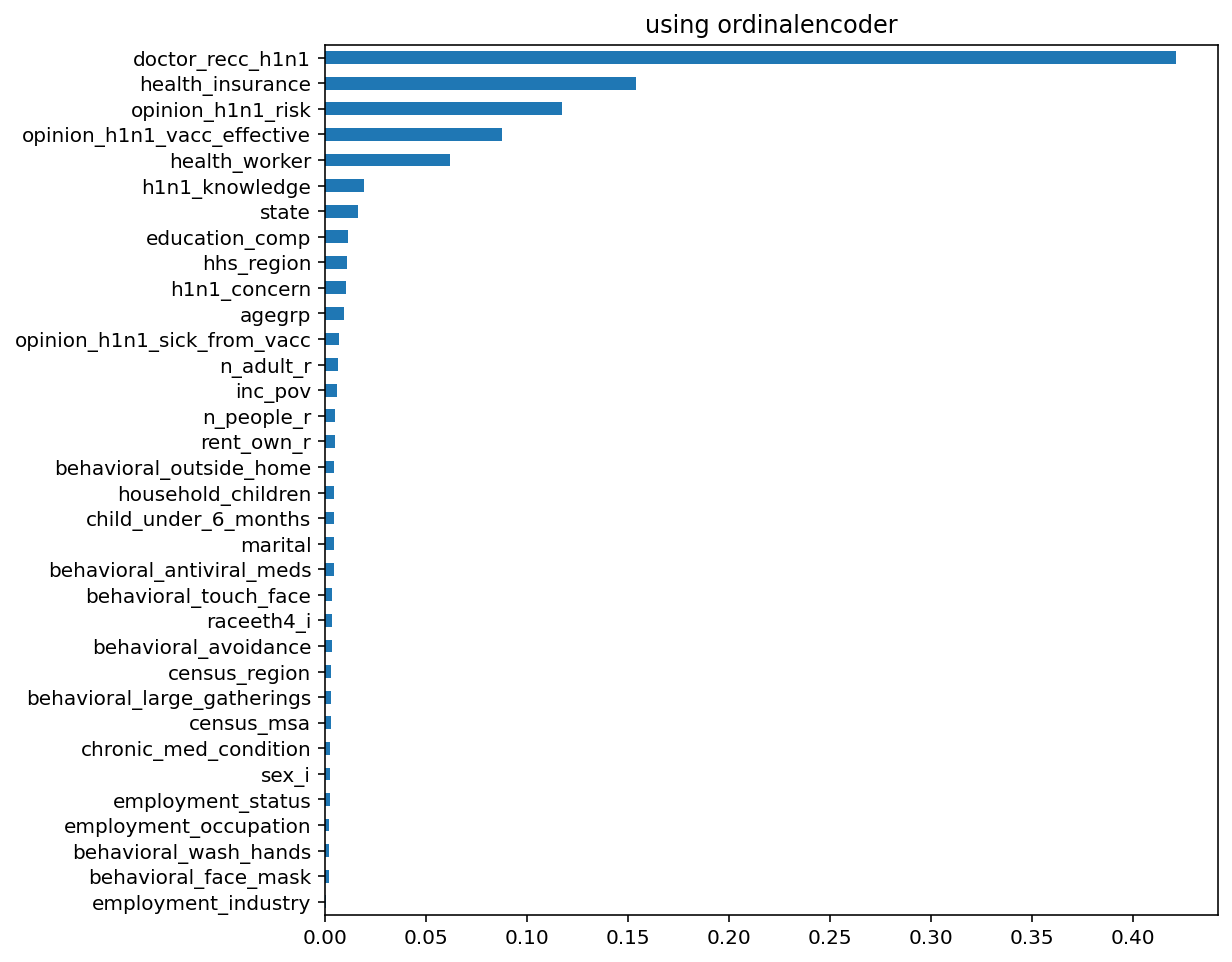

In [62]:
# 특성 중요도 파악

model_tree = pipe_DT.named_steps['decisiontreeclassifier']

orde = pipe_DT.named_steps['ordinalencoder']
orde_columns = orde.transform(X_train).columns
importances = pd.Series(model_tree.feature_importances_, orde.columns)

plt.figure(figsize = (8, 8))
plt.title('using ordinalencoder')
importances.sort_values().plot.barh();

원핫인코더를 사용했을 때와 각 특성의 중요도가 비슷한 부분도 있지만 조금 다른 양상을 띄는 것들이 있다. 예를 들어 원핫인코더를 사용할 때 삭제했던 state가 생각보다 특성 중요도에서 상위권에 위치하고, 연령대 또한 원핫인코더를 사용했을 때에는 보기 힘들었는데 어느정도 중요한 특성이라고 생각된다.

### 3) (도전과제🔥) 수업에 사용하지 않은 다른 종류의 [category_encoders](http://contrib.scikit-learn.org/category_encoders/)을 적용해 보고 인코더에 대해 설명하세요



In [68]:
from category_encoders import TargetEncoder

pipe_DT_different_encoder = make_pipeline(
    TargetEncoder(),
    IterativeImputer(max_iter = 20, random_state = 34),
    DecisionTreeClassifier(min_samples_split = 40, min_samples_leaf = 20, max_depth = 10, random_state = 34, criterion = 'entropy')
)

pipe_DT_different_encoder.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('targetencoder',
                 TargetEncoder(cols=['opinion_h1n1_vacc_effective',
                                     'opinion_h1n1_risk',
                                     'opinion_h1n1_sick_from_vacc', 'agegrp',
                                     'employment_status', 'census_msa',
                                     'employment_industry',
                                     'employment_occupation', 'state'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=1,
                               return_df=True, smoothi...
                                  skip_complete=False, tol=0.001, verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=10,
                                        max_features=No

In [75]:
y_train_pred = pipe_DT_different_encoder.predict(X_train)
y_val_pred = pipe_DT_different_encoder.predict(X_val)
print('accuracy score 훈련 :', pipe_DT_different_encoder.score(X_train, y_train))
print('accuracy score 검증 :', pipe_DT_different_encoder.score(X_val, y_val))
print('\nf1 score 훈련 :', f1_score(y_train, y_train_pred))
print('f1 score 검증 :', f1_score(y_val, y_val_pred))

te = pipe_DT_different_encoder.named_steps['targetencoder']
te_columns = te.transform(X_train).columns
print('\nlength of columns :', len(te_columns))
te_columns

accuracy score 훈련 : 0.8422441657029327
accuracy score 검증 : 0.8173407662199027

f1 score 훈련 : 0.6103135071784354
f1 score 검증 : 0.5564516129032259

length of columns : 34


Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'chronic_med_condition',
       'child_under_6_months', 'health_insurance', 'health_worker',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'agegrp', 'education_comp', 'raceeth4_i',
       'sex_i', 'inc_pov', 'marital', 'rent_own_r', 'employment_status',
       'census_region', 'census_msa', 'n_adult_r', 'household_children',
       'n_people_r', 'employment_industry', 'employment_occupation',
       'hhs_region', 'state'],
      dtype='object')

**TargetEncoder** : 타겟인코더를 사용했을 때 원핫,오디널보다 더 나은 측정 결과를 보이는 것 같으니 랜덤포레스트에도 똑같이 적용해보도록 하겠다.
- 종속 변수(target)의 정보를 사용하는 인코더 베이지안 인코더
- 차원을 늘리지 않으며, high cardinality 문제를 가진 데이터에 적합하게 작동함
- 분류문제에 적합
- 차원의 저주에 빠지기 쉬운 원핫인코딩의 단점을 상쇄할 수 있음
- 아래 예시에서 'animal group' 특성 중 'cat' 값을 가지고 있고 해당 데이터의 타겟값이 '1'이라면 (cat이면서 target1 / 전체데이터) 값으로 대체됨
- 마찬가지로 타겟(종속변수)가 연속형이라면 위와 같은 방식에서 평균값을 사용해서 대체됨

Ex.

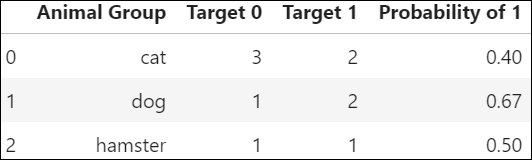


### 4) 랜덤포레스트 모델을 적용한 후의 결과를 캐글에 제출하세요(랜덤포레스트를 적용하고 성능이 오히려 떨어졌을 수도 있습니다! 만약 그렇다면 왜 그럴까 고민을 해 보고 적어주세요(정답이 아니여도 괜찮습니다. 본인 논리로 고찰하세요))

In [108]:
#랜덤포레스트 모델
%%time

pipe_RF = make_pipeline(
    TargetEncoder(),
    IterativeImputer(max_iter = 20, random_state = 34),
    RandomForestClassifier(n_estimators = 200, n_jobs = -1, max_features = 'auto',
                           max_depth = 10, oob_score = True, criterion = 'entropy', random_state = 34)
)

pipe_RF.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


CPU times: user 41.4 s, sys: 23.1 s, total: 1min 4s
Wall time: 33.6 s


In [85]:
# 랜덤포레스트 사용후 과적함이 심해짐

# estimator = 100

y_train_pred = pipe_RF.predict(X_train)
y_val_pred = pipe_RF.predict(X_val)

print('accuracy score 훈련 :', pipe_RF.score(X_train, y_train))
print('accuracy score 검증 :', pipe_RF.score(X_val, y_val))
print('\nf1 score 훈련 :', f1_score(y_train, y_train_pred))
print('f1 score 검증 :', f1_score(y_val, y_val_pred))



accuracy score 훈련 : 0.9964119443703111
accuracy score 검증 : 0.8140196892420828

f1 score 훈련 : 0.9924830713797602
f1 score 검증 : 0.5288461538461539


In [90]:
# 하이퍼파라미터 조정 후 과적합 해결
# TargetEncoder를 사용하였더니 검증데이터 스코어도 같이 증가함

# estimator = 100, min_samples_split = 40, min_samples_leaf = 20, max_depth = 10

y_train_pred = pipe_RF.predict(X_train)
y_val_pred = pipe_RF.predict(X_val)

print('accuracy score 훈련 :', pipe_RF.score(X_train, y_train))
print('accuracy score 검증 :', pipe_RF.score(X_val, y_val))
print('\nf1 score 훈련 :', f1_score(y_train, y_train_pred))
print('f1 score 검증 :', f1_score(y_val, y_val_pred))

accuracy score 훈련 : 0.8376775494469649
accuracy score 검증 : 0.8208990629818527

f1 score 훈련 : 0.5765779702970297
f1 score 검증 : 0.537660747091243


In [92]:
# estimator = 100, max_depth = 10

y_train_pred = pipe_RF.predict(X_train)
y_val_pred = pipe_RF.predict(X_val)

print('accuracy score 훈련 :', pipe_RF.score(X_train, y_train))
print('accuracy score 검증 :', pipe_RF.score(X_val, y_val))
print('\nf1 score 훈련 :', f1_score(y_train, y_train_pred))
print('f1 score 검증 :', f1_score(y_val, y_val_pred))

accuracy score 훈련 : 0.8545206535598849
accuracy score 검증 : 0.8231526509310877

f1 score 훈련 : 0.6210997837503861
f1 score 검증 : 0.5410895660203139


In [109]:
# estimator = 200, max_depth = 10

y_train_pred = pipe_RF.predict(X_train)
y_val_pred = pipe_RF.predict(X_val)

print('accuracy score 훈련 :', pipe_RF.score(X_train, y_train))
print('accuracy score 검증 :', pipe_RF.score(X_val, y_val))
print('\nf1 score 훈련 :', f1_score(y_train, y_train_pred))
print('f1 score 검증 :', f1_score(y_val, y_val_pred))

accuracy score 훈련 : 0.8556771343000327
accuracy score 검증 : 0.8227968212548926

f1 score 훈련 : 0.6257017611320465
f1 score 검증 : 0.5414364640883979


In [110]:
y_test_pred = pipe_RF.predict(X_test)
len(y_test_pred)

submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_data/prediction-of-h1n1-vaccination/submission.csv')
submission['vacc_h1n1_f'] = y_test_pred
submission.applymap(int)
submission.to_csv('submission.csv', index = False)

## 참고자료

- [Random Forests for Complete Beginners](https://victorzhou.com/blog/intro-to-random-forests/)